In [19]:
# Imports

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import FastICA, PCA
from sklearn.cluster import KMeans, DBSCAN
import os
from scipy.signal import find_peaks

(4, 1500)


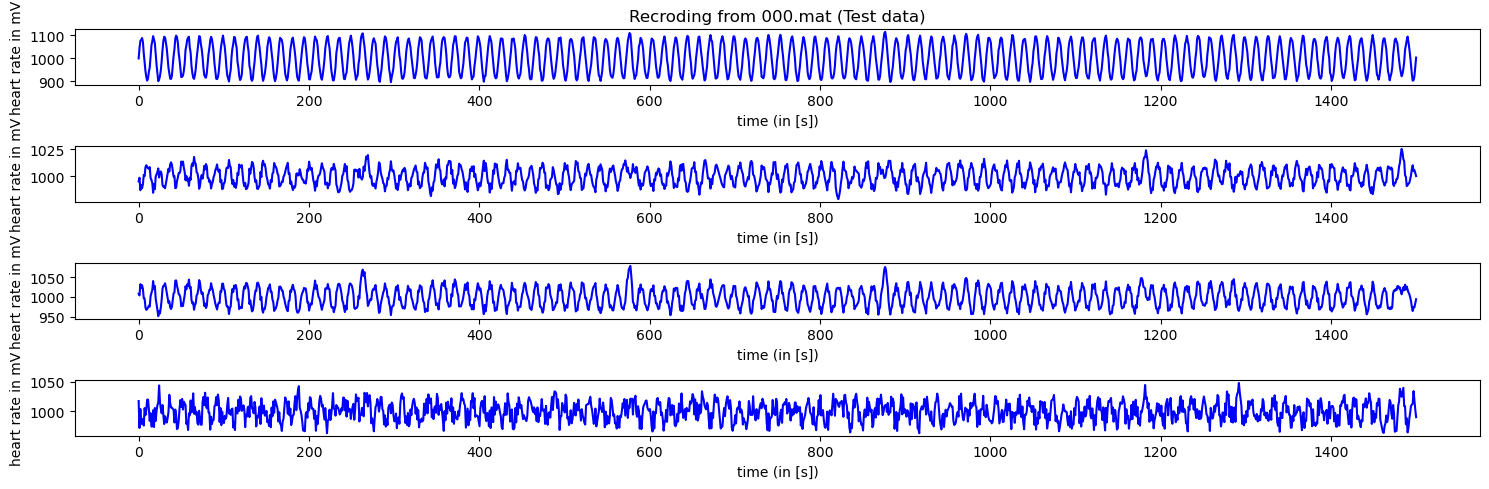

In [2]:
# Load data
mat_file_test_000 = loadmat('data/test-data/000.mat')

data00 = mat_file_test_000['val'].reshape(4,-1)

print(data00.shape)

fig, ax = plt.subplots(4,1, figsize=(15,5))


x = np.linspace(0, data00.shape[1], data00.shape[1])

for i in range(0,4):
    ax[i].plot(x, data00[i, :], color='blue', label=f'electrode {i}')
    ax[i].set_xlabel('time (in [s])')
    ax[i].set_ylabel('heart rate in mV')

ax[0].set_title('Recroding from 000.mat (Test data)')


plt.tight_layout()
plt.show()



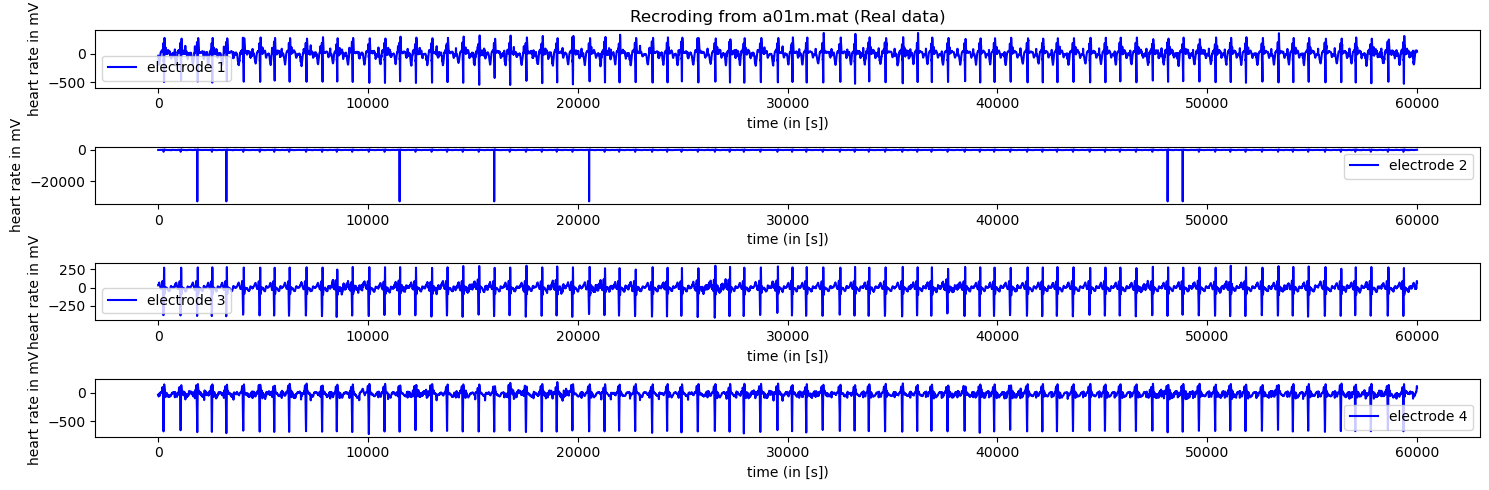

In [3]:
# Load data
mat_file_real_a01m = loadmat('data/real-data/a01m.mat')

data_r_01 = mat_file_real_a01m['val'].reshape(4,-1)

fig, ax = plt.subplots(4,1, figsize=(15,5))


x = np.linspace(0, data_r_01.shape[1], data_r_01.shape[1])

for i in range(0,4):
    ax[i].plot(x, data_r_01[i, :], color='blue', label=f'electrode {i+1}')
    ax[i].set_xlabel('time (in [s])')
    ax[i].set_ylabel('heart rate in mV')
    ax[i].legend()

ax[0].set_title('Recroding from a01m.mat (Real data)')


plt.tight_layout()
plt.show()

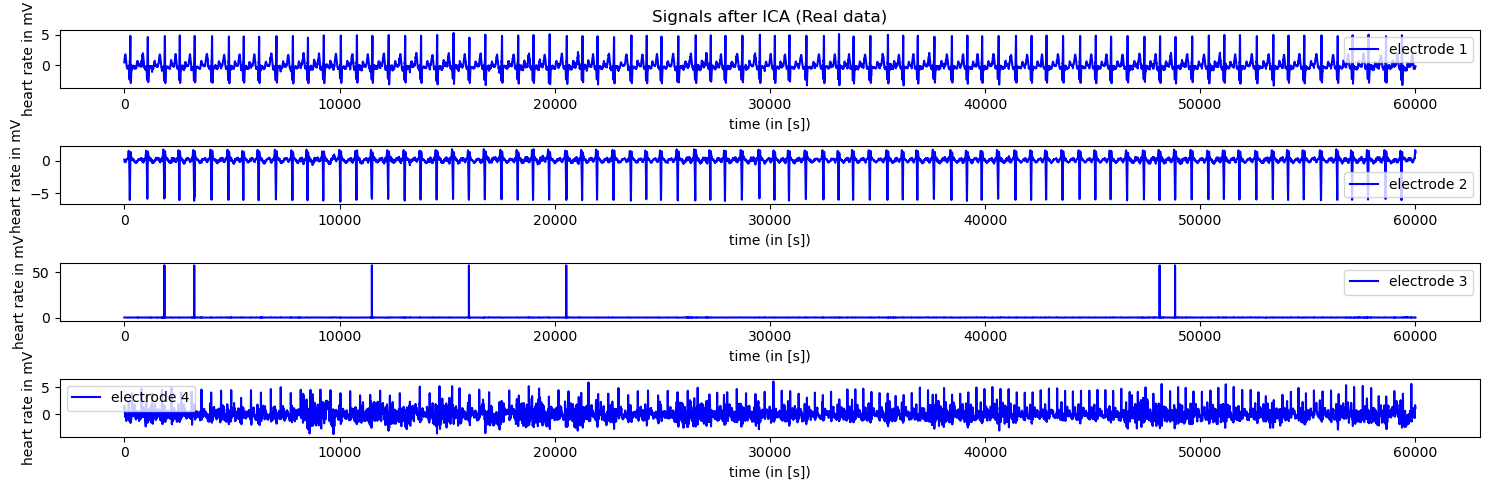

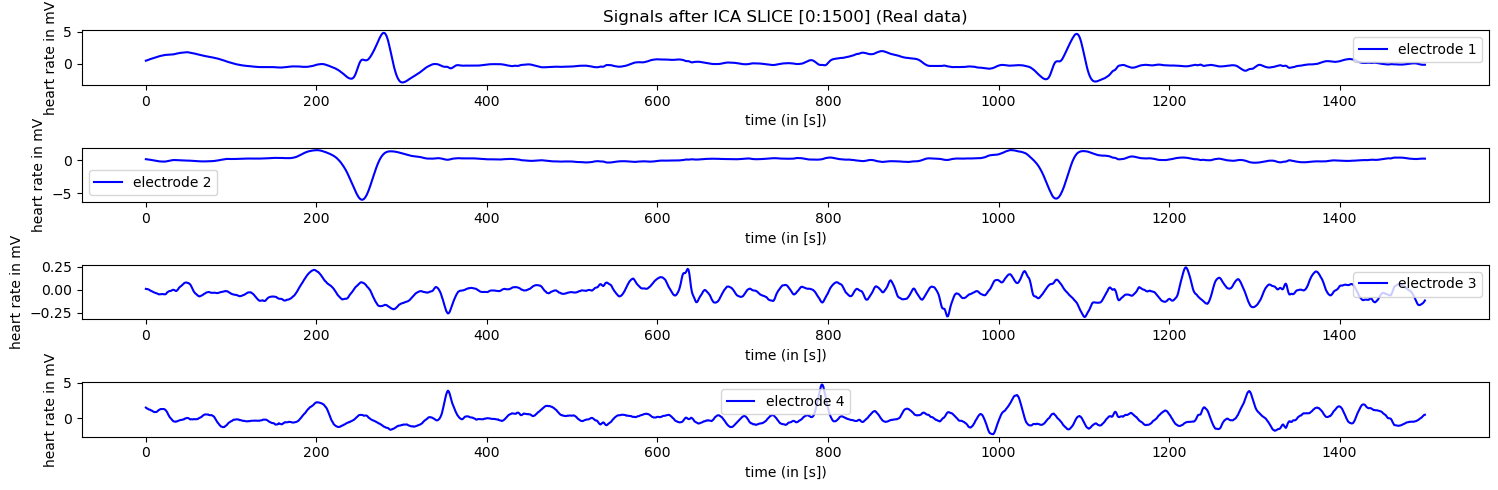

In [4]:
decomposed_data = FastICA(n_components=4).fit_transform(data_r_01.T).T

fig, ax = plt.subplots(4,1, figsize=(15,5))


x = np.linspace(0, decomposed_data.shape[1], decomposed_data.shape[1])

for i in range(0,4):
    ax[i].plot(x, decomposed_data[i, :], color='blue', label=f'electrode {i+1}')
    ax[i].set_xlabel('time (in [s])')
    ax[i].set_ylabel('heart rate in mV')
    ax[i].legend()

ax[0].set_title('Signals after ICA (Real data)')

plt.tight_layout()
plt.legend()
plt.show()


slice_start = 0
slice_end = 1500

fig, ax = plt.subplots(4,1, figsize=(15,5))


x = np.linspace(0, slice_end-slice_start, slice_end-slice_start)

for i in range(0,4):
    ax[i].plot(x, decomposed_data[i, :][slice_start:slice_end], color='blue', label=f'electrode {i+1}')
    ax[i].set_xlabel('time (in [s])')
    ax[i].set_ylabel('heart rate in mV')
    ax[i].legend()

ax[0].set_title(f'Signals after ICA SLICE [{slice_start}:{slice_end}] (Real data)')
plt.tight_layout()
plt.show()

# Identify Maternal and Fetal Heatbeat
## Fast Fourier Transform to remove the 2 noise signals

The next step is to analyze the period in the different signals. We expect the mothers' and fetous' hertbeat to have a distinct and similar pattern, while the noise deviates from this shape. 

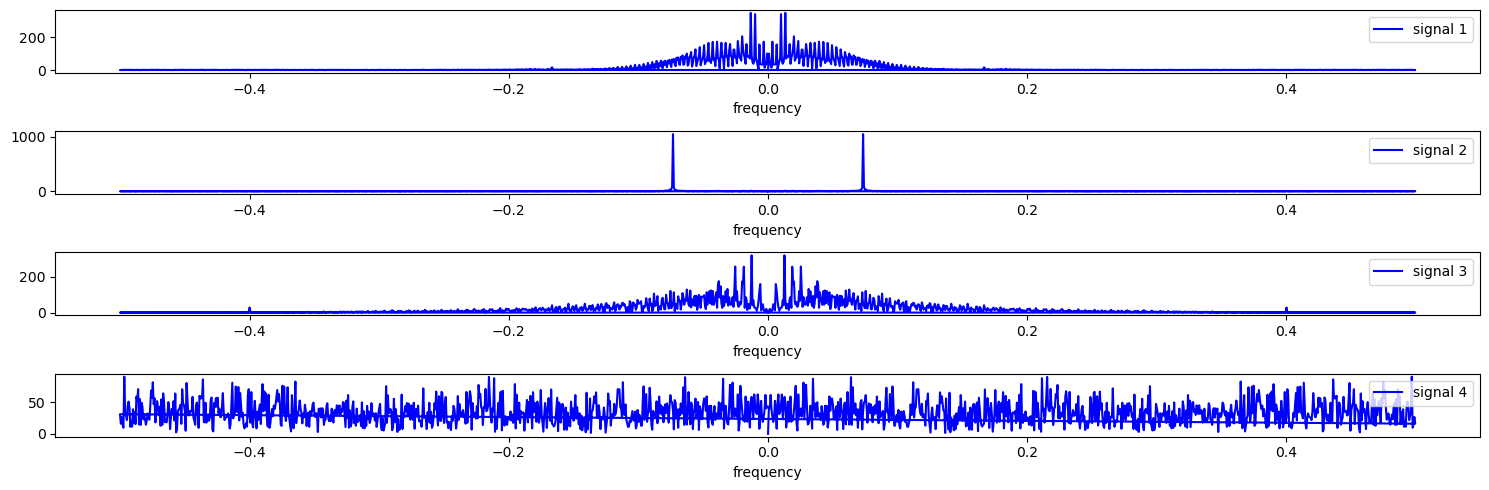

In [5]:
%matplotlib inline

decomposed_data = FastICA(n_components=4).fit_transform(data00.T).T

fft_out = np.fft.fft(decomposed_data, axis=1)
fft_freq = np.fft.fftfreq(decomposed_data.shape[1])



fig, ax = plt.subplots(4,1, figsize=(15,5))

for i in range(0,4):
    ax[i].plot(fft_freq, np.abs(fft_out[i, :]), color='blue', label=f'signal {i+1}')
    ax[i].set_xlabel('frequency')
    ax[i].set_ylabel('')
    ax[i].legend()

plt.tight_layout()
plt.show()

We can observe that there are two signals with a fairly regular pattern and two which heavily deviate from this. (both directions)

### Naive: Sum of signals

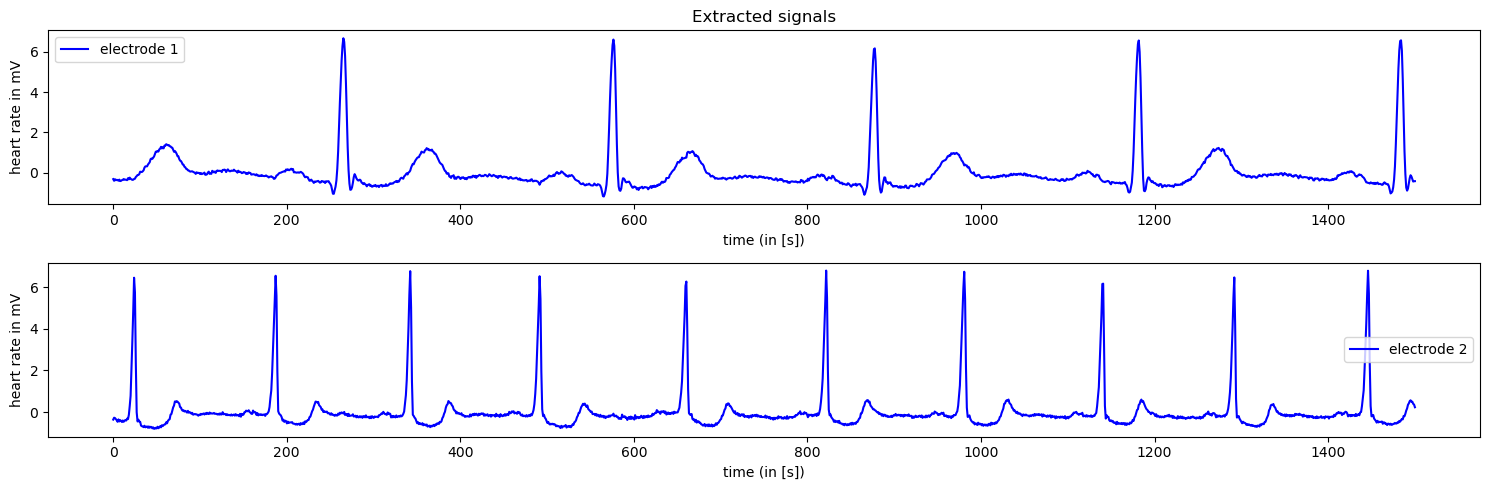

In [6]:
sum_of_signals = np.abs(fft_out.sum(axis=1))


idx_heatbeats = np.argsort(sum_of_signals)[1:3]

middle_1 = np.sort(sum_of_signals)[1]
middle_2 = np.sort(sum_of_signals)[2]

heartbeats = decomposed_data[idx_heatbeats]

fig, ax = plt.subplots(2,1, figsize=(15,5))

for i in range(0,2):
    ax[i].plot(x, heartbeats[i, :], color='blue', label=f'electrode {i+1}')
    ax[i].set_xlabel('time (in [s])')
    ax[i].set_ylabel('heart rate in mV')
    ax[i].legend()
    
ax[0].set_title(f'Extracted signals')

plt.tight_layout()
plt.show()


# Everything from above modularized
This function takes a file path and returns the heartbeats from the mixed signal

In [7]:
def extract_heatbeats(filename):
    # Open file
    mat_file = loadmat(filename)
    data = mat_file['val'].reshape(4,-1)    
    
    # ICA to extract signals from mixture
    decomposed_data = FastICA(n_components=4).fit_transform(data.T).T
    
    # FFT to distinguish heartbeat and noise
    fft_out = np.fft.fft(decomposed_data, axis=1)
    sum_of_signals = np.abs(fft_out.sum(axis=1))
    
    idx_heatbeats = np.argsort(sum_of_signals)[1:3]
    heartbeats = decomposed_data[idx_heatbeats]
    
    return heartbeats


directory = 'data/test-data'

all_test_heartbeats =[]

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        if filename.endswith('.mat'):
            heartbeats = extract_heatbeats(file_path)
            for h in heartbeats:
                all_test_heartbeats.append(h)
        
    
    

## Identify Irregular Signals

The irregularity is in the period of the signal.

Naive attempt: Thresholding to detect maximum of the signals, Calculate difference between spikes (period length), Varaince should be low for regular heartbeat\
Why naive: We cannot really make assumptions on how a healthy heartbeat period looks. Depending on the state of the person there might be varying periods.

In [8]:
heartbeats = extract_heatbeats('data/test-data/000.mat')

peaks, _ = find_peaks(heartbeats[0])

distance_between_peaks = []
for i in range(1, len(peaks)):
    distance_between_peaks.append(peaks[i] - peaks[i-1])
    
variance = np.array(distance_between_peaks).var()
std = np.array(distance_between_peaks).std()
mean = np.array(distance_between_peaks).mean()


print(peaks)
print(distance_between_peaks)
print(variance)
print(std)
print(mean)


[   2    4    7   12   14   17   19   31   37   44   49   51   55   57
   59   61   64   71   91   96   98  101  105  110  112  114  117  120
  122  126  128  132  136  139  144  146  150  154  156  161  165  167
  169  171  176  182  197  199  201  205  207  209  213  216  222  228
  232  236  240  243  245  248  265  278  284  289  295  297  300  302
  305  309  311  314  319  321  326  328  332  338  345  355  361  363
  365  367  371  386  388  392  394  397  401  403  406  410  412  415
  417  419  422  425  428  433  438  442  444  446  450  453  458  464
  468  470  473  476  479  482  485  487  493  495  502  504  507  511
  516  522  525  528  541  545  548  554  558  576  587  592  594  600
  604  609  612  619  621  623  626  628  632  634  637  650  653  655
  662  667  671  673  690  695  698  700  702  705  710  716  719  721
  728  734  736  739  744  746  749  753  757  763  766  768  770  774
  776  778  782  786  790  792  794  798  800  803  806  808  811  816
  818 

/tmp/ipykernel_11033/1249303954.py:27: RuntimeWarning: Degrees of freedom <= 0 for slice
  variance = np.array(distance_between_peaks).var()
/home/henriette/miniconda3/envs/ml-basics-10/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/henriette/miniconda3/envs/ml-basics-10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/henriette/miniconda3/envs/ml-basics-10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_11033/1249303954.py:29: RuntimeWarning: Mean of empty slice.
  mean = np.array(distance_between_peaks).mean()
/home/henriette/miniconda3/envs/ml-basics-10/lib/python3.10/site-packages/numpy/core/_methods.py:

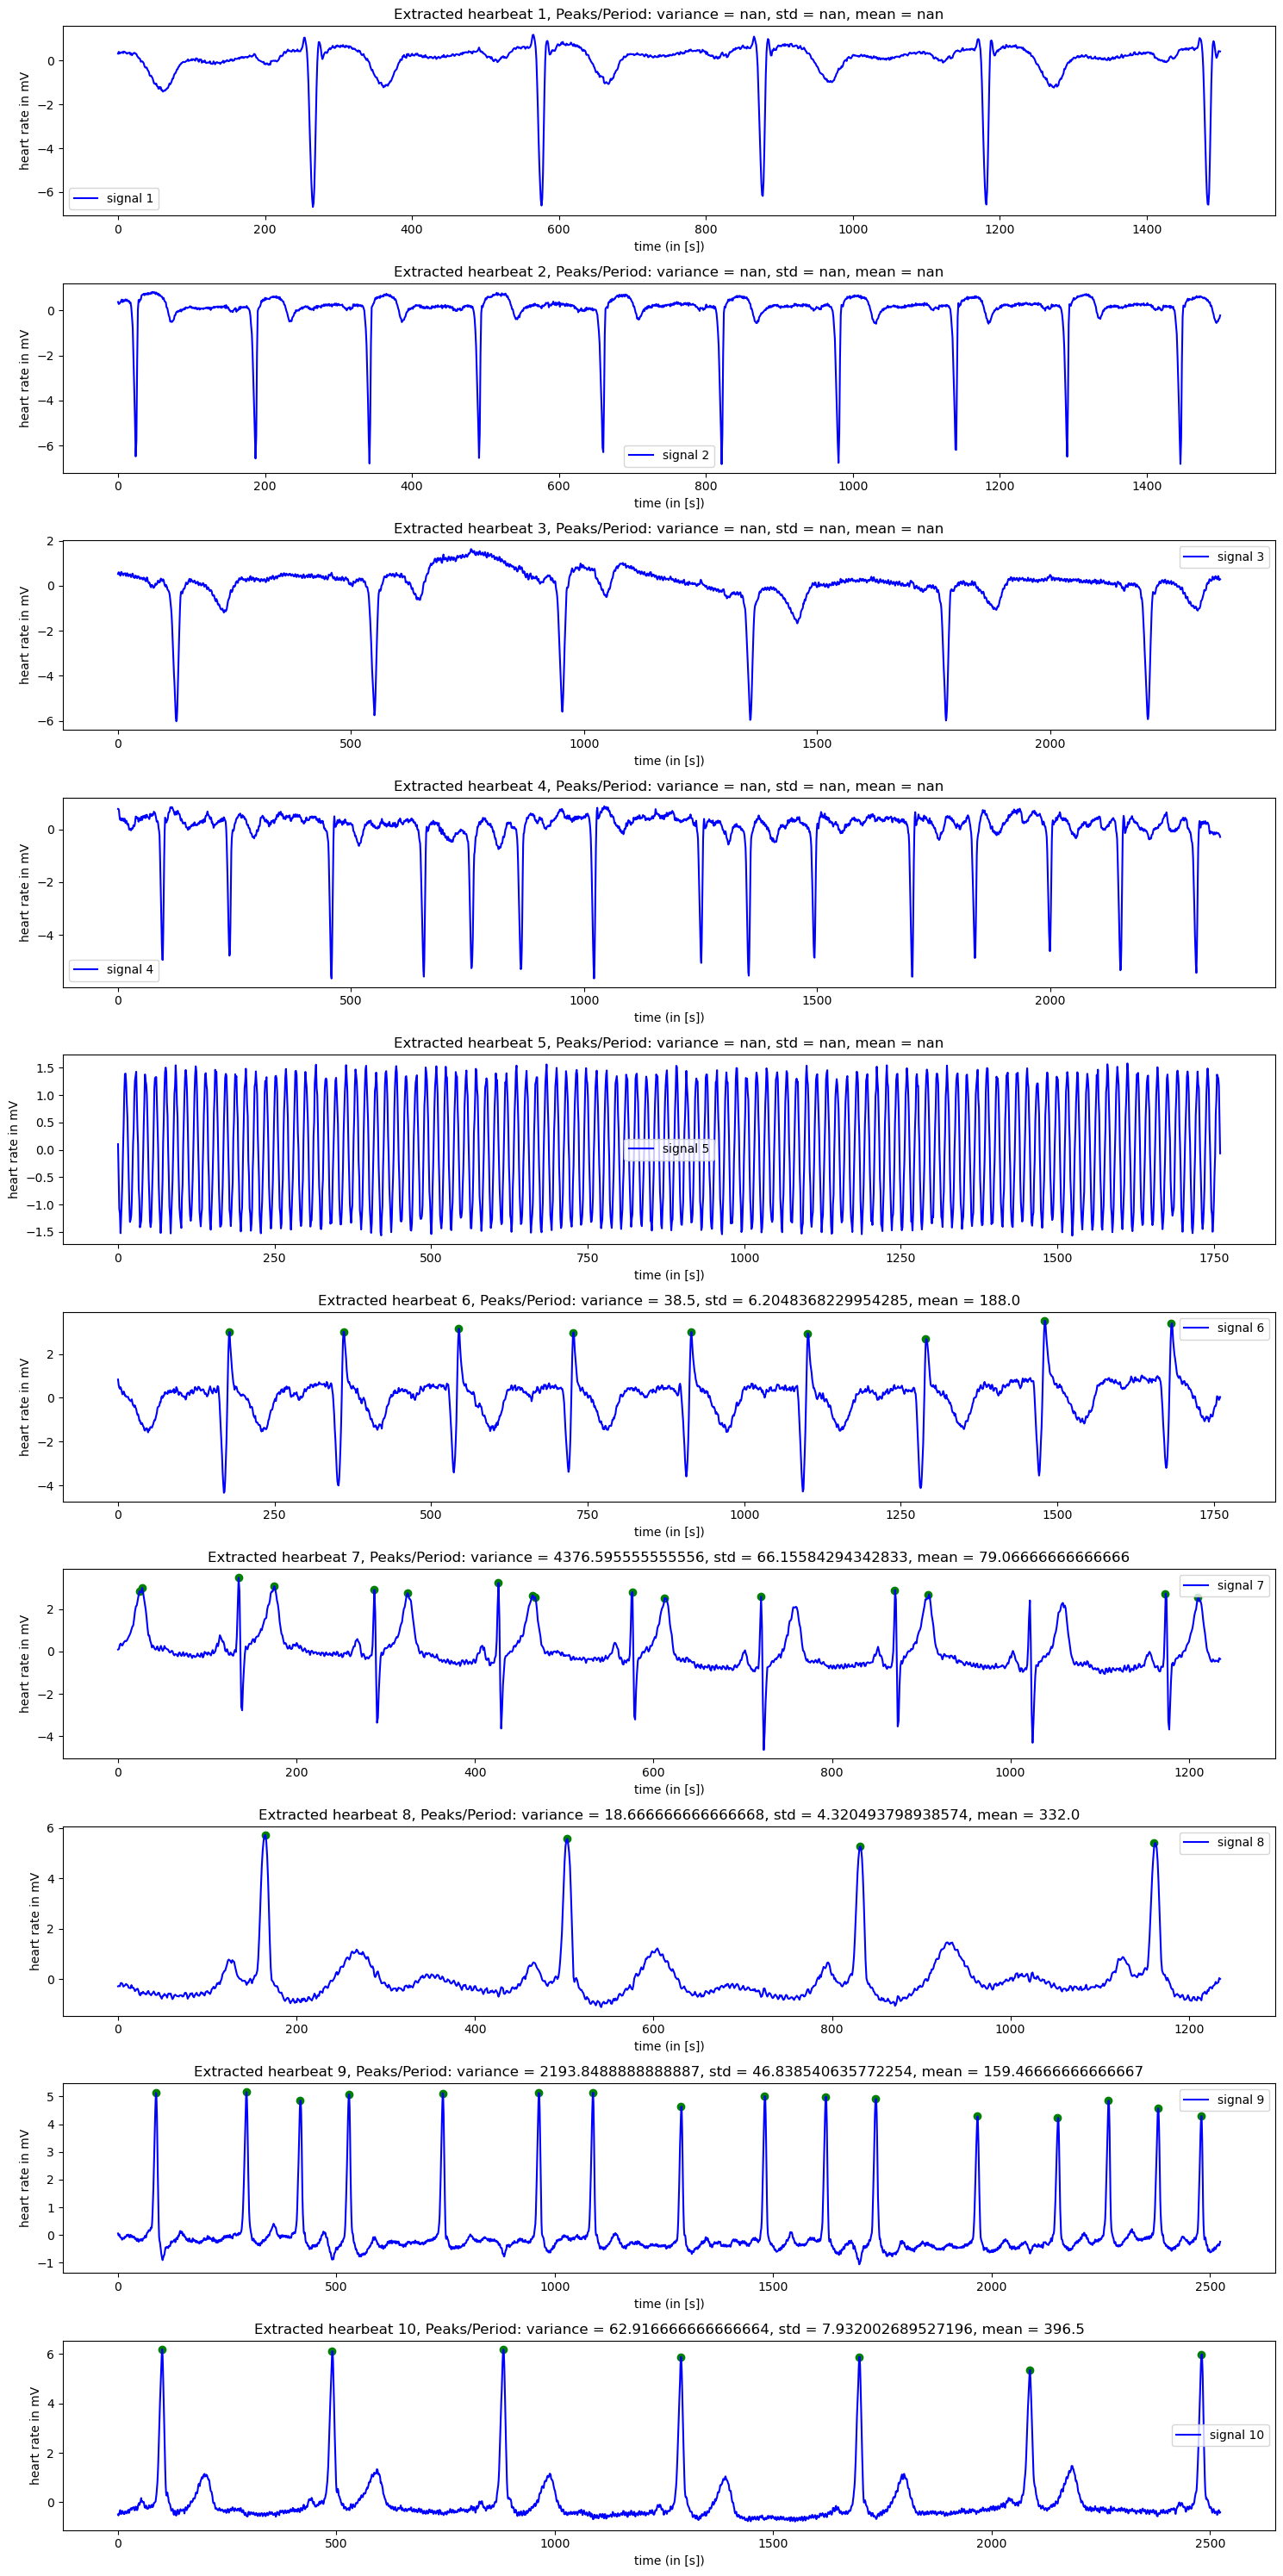

In [9]:
directory = 'data/test-data'

all_test_heartbeats =[]

for filename in sorted(os.listdir(directory)):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        if filename.endswith('.mat'):
            heartbeats = extract_heatbeats(file_path)
            for h in heartbeats:
                all_test_heartbeats.append(h)
                
_from = 0
_to = 10

fig, ax = plt.subplots(_to-_from,1, figsize=(15,30))

for idx, heartbeat in enumerate(all_test_heartbeats[_from:_to]):
    x = np.linspace(0, heartbeat.shape[0], heartbeat.shape[0])
    
    peaks, _ = find_peaks(heartbeat, height=2.5)

    distance_between_peaks = []
    for i in range(1, len(peaks)):
        distance_between_peaks.append(peaks[i] - peaks[i-1])
        
    variance = np.array(distance_between_peaks).var()
    std = np.array(distance_between_peaks).std()
    mean = np.array(distance_between_peaks).mean()
    
    ax[idx].plot(x, heartbeat, color='blue', label=f'signal {idx+1}')
    ax[idx].scatter(peaks, heartbeat[peaks], color='green')
    
    ax[idx].set_xlabel('time (in [s])')
    ax[idx].set_ylabel('heart rate in mV')
    ax[idx].legend()
    ax[idx].set_title(f'Extracted hearbeat {idx+ 1 + _from}, Peaks/Period: variance = {variance}, std = {std}, mean = {mean}')

plt.tight_layout()
plt.show()
    

### Clustering 
Assume that the majority of data points / heartbeats are regular and that they are forming a large cluster. \
Find outliers from such a cluster, or that form smaller clusters\

One issue here could be that the maternal and fetal signal are different from the beginning (fetal is faster); No idea if this is actually true


Maybe a GMM clustering would be usefull. Then we have probabilities that a hearbeat is regular and not

DBSCAN could actually work better

# Clustering

Hwo do different clustering algorithms look like --> How do the identified clusters come together (this is actually very different)
kmeans will identify as many clusters as you tell it to find this means that there are not really outliers there -- clearly distributed clusters
dbscan can identify clusters of points that are not necessarily centred around a point, it relies on the distance between the data points
gmm gives probability for points to belong to a cluster -- basicly finds the probability distributions (they can merge) meaning a point can belong to two clusters or more

## ICA -- PCA -- Clustering
We process the mixture of singals with PCA. The result are two heartbeat signals and 2 noise signals. We do not extract the noise signals. Instead, we pass all signals into PCA to reduce the dimensionality. The output is then clustered. The next step ist to analysie those clusters to identify the irregular heartbeats. \

One issue that arises is that not all the signals have the same length. Therefore, we need to apply padding to the signals. 

### Extract all signals (ICA)

In [10]:
all_signals = []

directory = 'data/test-data'

for filename in sorted(os.listdir(directory)):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        if filename.endswith('.mat'):
            # Open file
            mat_file = loadmat(file_path)
            data = mat_file['val'].reshape(4,-1)    
            
            # ICA to extract signals from mixture
            decomposed_data = FastICA(n_components=4).fit_transform(data.T).T
        
            for d in decomposed_data:
                all_signals.append(d)
                
            

### Apply padding
pad to the maximum signal length\
padding mode: edge --> repeat the values at the edge of the array\
we are padding at the end of the signal only \


In [11]:
max_signal_length = max(len(s) for s in all_signals)
all_signals = np.array([np.pad(s, (0, max_signal_length - s.shape[0]), mode='constant') for s in all_signals])
print(all_signals.shape)

# TODO: Impact of padding should be evaluated and explained in presentation

(612, 2605)


### Reduce dimensionality (PCA)

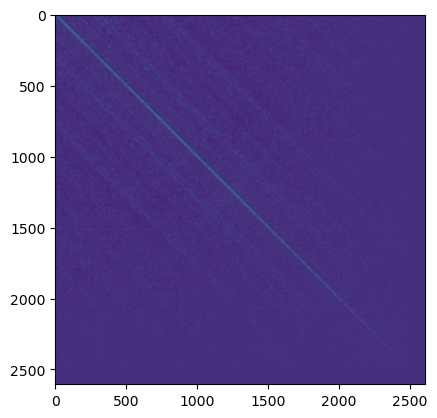

In [12]:
%matplotlib inline

covariance_matrix = np.cov(all_signals.T)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(covariance_matrix)

We can observe that there seems to be variance in a very limited number of dimensions. (If not graphic bug)\
We can also see that it is very evenly distributed. 

/home/henriette/miniconda3/envs/ml-basics-10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/henriette/miniconda3/envs/ml-basics-10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


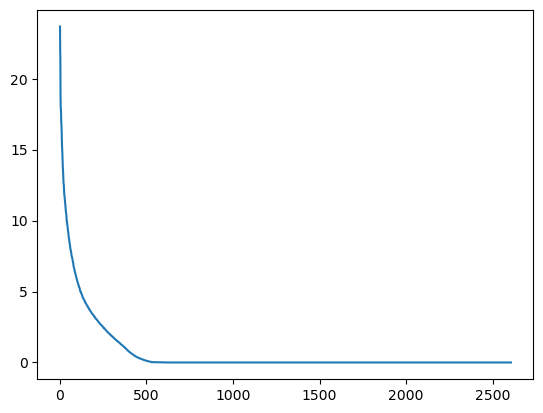

In [14]:
%matplotlib inline
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
eigenvalues = np.sort(eigenvalues)[::-1]
plt.plot(np.linspace(1, len(eigenvalues), num=len(eigenvalues)), eigenvalues)

plt.show()

In [18]:
total_variance_kept = eigenvalues[0:300].sum()
total_variance = eigenvalues.sum()

ratio_kept = total_variance_kept / total_variance

print(f'Variance kept: {total_variance_kept}, total variance: {total_variance}, ratio kept: {ratio_kept}')

Variance kept: (1686.8330947090558+0j), total variance: (1859.037839906745-2.9582283945787943e-31j), ratio kept: (0.9073688864739153+1.4438675462674424e-34j)


In [20]:
pca = PCA(n_components=10)
X = pca.fit_transform(all_signals)

### Clustering
TODO: Why which method and paramters

In [21]:
cluster = DBSCAN(eps=0.2, min_samples=2, metric='euclidean').fit(X)

# TODO: visualize the clusters in some way or form